In [1]:
# ============================================================
# 🔰 Deployment: Predict Quadrant (Cassandra + Auto Compute Indicators + Marketcap)
# ============================================================

from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# -----------------------------
# 1. Connect Cassandra (Local)
# -----------------------------
def connect_cassandra():
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
    session.set_keyspace('data_stock')  # 👈 ตั้ง keyspace ให้ตรงกับที่คุณสร้างไว้
    return session


# -----------------------------
# 2. ดึงข้อมูลจาก Cassandra
# -----------------------------
def get_stock_data(session, symbol):
    # ข้อมูลราคาหลัก
    q_price = f"""
        SELECT time, close_price, high_price, low_price, open_price, value
        FROM candlestick_data
        WHERE symbol='{symbol}'
        LIMIT 300;
    """
    # ข้อมูล volume สำหรับคำนวณ marketcap
    q_vol = f"""
        SELECT time, volume
        FROM candlestick1_1068_data
        WHERE symbol='{symbol}'
        LIMIT 300;
    """
    # ข้อมูลพื้นฐาน
    q_fund = f"""
        SELECT eps, pe, pbv, percentyield
        FROM financal_data_fromsettradeAPI
        WHERE symbol='{symbol}'
        LIMIT 1;
    """

    df_price = pd.DataFrame(session.execute(q_price).all())
    df_vol = pd.DataFrame(session.execute(q_vol).all())
    fund = session.execute(q_fund).one()

    if df_price.empty or df_vol.empty or not fund:
        raise ValueError(f"❌ ไม่มีข้อมูลครบสำหรับ {symbol}")

    df_price = df_price.sort_values("time")
    df_vol = df_vol.sort_values("time")

    # รวม price + volume ตามเวลา
    df = pd.merge(df_price, df_vol, on="time", how="inner")
    df["marketcap"] = df["close_price"] * df["volume"]

    return df, fund._asdict()


# -----------------------------
# 3. คำนวณ EMA และ RSI
# -----------------------------
def compute_indicators(df):
    # EMA หลายช่วงเวลา
    df["ema5"] = df["close_price"].ewm(span=5, adjust=False).mean()
    df["ema15"] = df["close_price"].ewm(span=15, adjust=False).mean()
    df["ema35"] = df["close_price"].ewm(span=35, adjust=False).mean()
    df["ema89"] = df["close_price"].ewm(span=89, adjust=False).mean()
    df["ema200"] = df["close_price"].ewm(span=200, adjust=False).mean()

    # RSI 14
    delta = df["close_price"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["rsi"] = 100 - (100 / (1 + rs))

    df = df.dropna().reset_index(drop=True)
    return df


# -----------------------------
# 4. ทำนาย Quadrant ด้วย Deep Learning
# -----------------------------
def predict_quadrant(symbol):
    session = connect_cassandra()
    df, fund_data = get_stock_data(session, symbol)
    df = compute_indicators(df)

    # ใช้ข้อมูลล่าสุด (แถวสุดท้าย)
    last = df.iloc[-1]

    input_data = {
        **fund_data,
        "marketcap": last["marketcap"],
        "close_price": last["close_price"],
        "high_price": last["high_price"],
        "low_price": last["low_price"],
        "open_price": last["open_price"],
        "value": last["value"],
        "ema5": last["ema5"],
        "ema15": last["ema15"],
        "ema35": last["ema35"],
        "ema89": last["ema89"],
        "ema200": last["ema200"],
        "rsi": last["rsi"]
    }

    # เรียงฟีเจอร์ให้ตรงกับที่เทรนโมเดล
    features = ["eps", "pe", "pbv", "percentyield", "marketcap",
                "close_price", "high_price", "low_price", "open_price",
                "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"]

    X = np.array([[input_data[f] for f in features]])

    # โหลดโมเดลและเครื่องมือ
    deep_model = load_model("deep_quadrant_model.h5")
    scaler = joblib.load("scaler.pkl")
    le = joblib.load("label_encoder.pkl")

    # สเกลข้อมูล
    X_scaled = scaler.transform(X)
    y_pred = deep_model.predict(X_scaled)
    y_class = np.argmax(y_pred, axis=1)
    quadrant = le.inverse_transform(y_class)[0]

    return quadrant, input_data


# -----------------------------
# 5. ทดสอบระบบ
# -----------------------------
try:
    symbol = input("🔎 พิมพ์ชื่อหุ้น (เช่น AOT): ").upper()
    quadrant, used_data = predict_quadrant(symbol)

    print(f"\n✅ หุ้น {symbol} อยู่ใน Quadrant → {quadrant}")
    print("\n📊 ข้อมูลที่ใช้ในการวิเคราะห์:")
    for k, v in used_data.items():
        print(f"  {k:15s}: {v:.2f}")

except Exception as e:
    print("❌ เกิดข้อผิดพลาด:", e)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step

✅ หุ้น AOT อยู่ใน Quadrant → Ab

📊 ข้อมูลที่ใช้ในการวิเคราะห์:
  eps            : 1.00
  pe             : 29.10
  pbv            : 4.25
  percentyield   : 2.09
  marketcap      : 1266001848.00
  close_price    : 72.00
  high_price     : 73.00
  low_price      : 72.00
  open_price     : 72.75
  value          : 0.00
  ema5           : 72.39
  ema15          : 71.91
  ema35          : 71.51
  ema89          : 71.55
  ema200         : 71.91
  rsi            : 59.26


ERROR:cassandra.connection:Closing connection <AsyncoreConnection(2081518373760) 127.0.0.1:9042> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"
ERROR:cassandra.connection:Closing connection <AsyncoreConnection(2082517756240) 127.0.0.1:9042> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"
ERROR:cassandra.connection:Closing connection <AsyncoreConnection(2082519249776) 127.0.0.1:9042> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"
ERROR:cassandra.connection:Closing connection <AsyncoreConnection(2082537306672) 127.0.0.1:9042> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


In [2]:
# ============================================================
# 🔰 Predict Multiple Stocks and Combine into DataFrame
# ============================================================

import pandas as pd

# สมมติว่าคุณมีฟังก์ชันนี้จากขั้นตอนก่อนหน้าแล้ว
# def predict_quadrant(symbol): -> return quadrant, input_data

# -----------------------------
# 1. รายชื่อหุ้นที่ต้องการทำนาย
# -----------------------------
symbols = ["DELTA", "PTT", "AOT", "ADVANC", "KBANK", 
           "TRUE", "GULF", "SCB", "KTC", "KTB", "CPALL"]

# -----------------------------
# 2. วนลูปทำนายหุ้นแต่ละตัว
# -----------------------------
results = []
for sym in symbols:
    try:
        quadrant, data_used = predict_quadrant(sym)
        row = {"Symbol": sym, "Quadrant": quadrant}
        row.update(data_used)  # รวมฟีเจอร์ที่ใช้ในการทำนาย (optional)
        results.append(row)
        print(f"✅ {sym} → {quadrant}")
    except Exception as e:
        print(f"❌ {sym}: {e}")

# -----------------------------
# 3. รวมผลเป็น DataFrame
# -----------------------------
df_pred = pd.DataFrame(results)

# แสดงเฉพาะคอลัมน์สำคัญ
cols_show = ["Symbol", "Quadrant", "eps", "pe", "pbv", "percentyield", 
             "marketcap", "close_price", "ema5", "ema15", "ema35", "rsi"]
df_show = df_pred[cols_show].round(2)

print("\n📊 ผลการทำนายทั้งหมด:")
display(df_show)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


✅ DELTA → Ac


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


✅ PTT → Ad


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


✅ AOT → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


✅ ADVANC → Ac


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


✅ KBANK → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


✅ TRUE → Ab


❌ GULF: ❌ ไม่มีข้อมูลครบสำหรับ GULF


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


✅ SCB → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


✅ KTC → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step


✅ KTB → Ac


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
✅ CPALL → Ab

📊 ผลการทำนายทั้งหมด:


,Symbol,Quadrant,eps,pe,pbv,percentyield,marketcap,close_price,ema5,ema15,ema35,rsi
0,DELTA,Ac,0.81,100.50,21.75,0.31,5.194120e+08,109.00,108.85,107.59,106.02,58.73
1,PTT,Ad,1.57,12.86,0.80,6.62,1.744858e+09,34.75,35.07,35.33,34.93,30.77
2,AOT,Ab,1.00,29.10,4.25,2.09,1.266002e+09,72.00,72.39,71.91,71.51,59.26
3,ADVANC,Ac,7.25,21.85,8.51,3.65,9.322627e+08,213.00,215.24,217.95,218.91,31.82
4,KBANK,Ab,5.67,8.09,0.68,7.19,8.519348e+08,130.50,130.65,130.06,129.43,62.07
5,TRUE,Ab,0.11,0.00,5.08,0.00,8.345208e+08,8.70,8.54,8.43,8.20,52.38
6,SCB,Ab,7.51,9.03,0.90,8.12,7.943464e+08,118.50,117.80,116.09,113.50,76.19
7,KTC,Ab,1.46,9.46,1.78,4.76,2.434419e+08,47.00,47.87,47.60,47.57,55.56
8,KTB,Ac,0.84,7.54,0.74,6.44,8.139685e+08,19.00,19.28,19.52,19.64,35.48
9,CPALL,Ab,1.57,14.91,3.18,3.00,1.141302e+09,64.50,64.99,64.30,63.45,67.86


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

e:\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
e:\Anaconda\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ Saved prediction results to: predicted_quadrants.xlsx


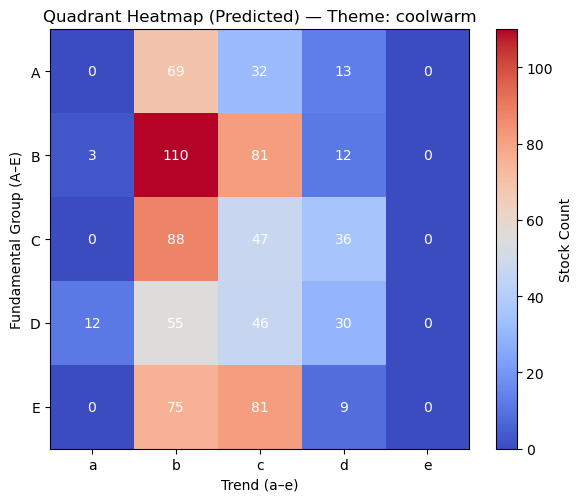


📊 Quadrant Count Matrix:
Trend         a    b   c   d  e
Fundamental                    
A             0   69  32  13  0
B             3  110  81  12  0
C             0   88  47  36  0
D            12   55  46  30  0
E             0   75  81   9  0


In [2]:
# ============================================================
# 🔰 Deployment: Predict All Stocks from Excel + Quadrant Heatmap
# ============================================================

import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ โหลดไฟล์ Excel และโมเดล
# -----------------------------
excel_path = "fileformodel.xlsx"
model_path = "deep_quadrant_model.h5"
scaler_path = "scaler.pkl"
le_path = "label_encoder.pkl"

df = pd.read_excel(excel_path)
deep_model = load_model(model_path)
scaler = joblib.load(scaler_path)
le = joblib.load(le_path)

# -----------------------------
# 2️⃣ เตรียมฟีเจอร์ที่ใช้เทรนโมเดล
# -----------------------------
features = [
    "eps", "pe", "pbv", "percentyield", "marketcap",
    "close_price", "high_price", "low_price", "open_price",
    "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"
]

# ตรวจสอบว่าฟีเจอร์ครบไหม
missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"❌ ขาดคอลัมน์: {missing}")

# -----------------------------
# 3️⃣ เตรียมข้อมูลและสเกล
# -----------------------------
X = df[features].replace([np.inf, -np.inf], np.nan)
for c in X.columns:
    X[c] = X[c].fillna(X[c].median())

X_scaled = scaler.transform(X)

# -----------------------------
# 4️⃣ ทำนาย Quadrant ทั้งหมด
# -----------------------------
y_pred = deep_model.predict(X_scaled)
y_class = np.argmax(y_pred, axis=1)
df["Predicted Quadrant"] = le.inverse_transform(y_class)

# -----------------------------
# 5️⃣ บันทึกผลลัพธ์ทั้งหมด
# -----------------------------
output_file = "predicted_quadrants.xlsx"
df.to_excel(output_file, index=False)
print(f"✅ Saved prediction results to: {output_file}")
# -----------------------------
# 6️⃣ สร้างตารางนับจำนวนหุ้นแต่ละ Quadrant
# -----------------------------
# แยก Quadrant ออกเป็น 2 ส่วน เช่น A–E และ a–e
df["Fundamental"] = df["Predicted Quadrant"].str[0]
df["Trend"] = df["Predicted Quadrant"].str[1]

financial_levels = ["A", "B", "C", "D", "E"]
trend_levels = ["a", "b", "c", "d", "e"]

# สร้าง pivot table เพื่อนับจำนวนในแต่ละ Quadrant
heatmap_data = pd.pivot_table(
    df,
    index="Fundamental",
    columns="Trend",
    values="symbol",
    aggfunc="count",
    fill_value=0
).reindex(index=financial_levels, columns=trend_levels, fill_value=0)

# -----------------------------
# 7️⃣ วาด Heatmap (กำหนดโทนสีเอง)
# -----------------------------
import matplotlib.pyplot as plt
import numpy as np


color_theme = "coolwarm"

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(heatmap_data.values, cmap=color_theme)

# ตั้งค่าฉลากแกน
ax.set_xticks(np.arange(len(trend_levels)))
ax.set_yticks(np.arange(len(financial_levels)))
ax.set_xticklabels(trend_levels)
ax.set_yticklabels(financial_levels)
ax.set_xlabel("Trend (a–e)")
ax.set_ylabel("Fundamental Group (A–E)")
ax.set_title(f"Quadrant Heatmap (Predicted) — Theme: {color_theme}")

# ใส่จำนวนในแต่ละช่อง
for i in range(len(financial_levels)):
    for j in range(len(trend_levels)):
        ax.text(j, i, int(heatmap_data.values[i, j]), ha="center", va="center", color="white", fontsize=10)

# เพิ่มแถบสีด้านข้าง
cbar = plt.colorbar(im)
cbar.set_label("Stock Count")

plt.tight_layout()
plt.show()


# แสดงตารางสรุปจำนวนหุ้นแต่ละ Quadrant
print("\n📊 Quadrant Count Matrix:")
print(heatmap_data)


In [3]:
df_original = pd.read_excel("stock_all_data.xlsx")
df_predicted =df

In [4]:
df.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'volume', 'marketcap',
       'score', 'time', 'close_price', 'high_price', 'low_price', 'open_price',
       'value', 'ema5', 'ema15', 'ema35', 'ema89', 'ema200', 'rsi',
       'Predicted Quadrant', 'Fundamental', 'Trend'],
      dtype='object')

In [5]:
merged = pd.merge(
    df_original,
    df_predicted[["symbol", "Predicted Quadrant"]],
    on="symbol",
    how="inner",
    suffixes=("_actual", "_predicted")
)

# -----------------------------
# 3️⃣ เปรียบเทียบ Quadrant เดิม vs ทำนาย
# -----------------------------
merged["Match"] = merged.apply(
    lambda x: "✅ Same" if x["quadrant"] == x["Predicted Quadrant"] else "❌ Different",
    axis=1
)

# -----------------------------
# 4️⃣ แสดงผลการเปรียบเทียบ
# -----------------------------
comparison = merged[["symbol", "quadrant", "Predicted Quadrant", "Match"]]
print(comparison)

# -----------------------------
# 5️⃣ นับจำนวนที่ตรง / ไม่ตรง
# -----------------------------
summary = comparison["Match"].value_counts()
print("\n📊 Summary:")
print(summary)

    symbol quadrant Predicted Quadrant        Match
0     PPPM       Dd                 Dd       ✅ Same
1     TPCH       Ac                 Bb  ❌ Different
2     POLY       Ac                 Bc  ❌ Different
3     VCOM       Ab                 Ab       ✅ Same
4      NVD       Ed                 Ec  ❌ Different
..     ...      ...                ...          ...
794    TFM       Ab                 Ab       ✅ Same
795  TRITN       Ed                 Ec  ❌ Different
796     I2       Bd                 Bc  ❌ Different
797   SPRC       Bd                 Bc  ❌ Different
798  BLAND       Db                 Db       ✅ Same

[799 rows x 4 columns]

📊 Summary:
Match
✅ Same         502
❌ Different    297
Name: count, dtype: int64


In [6]:
# -----------------------------
# 2️⃣ รวมข้อมูลโดยใช้ Symbol เป็นกุญแจ
# -----------------------------
merged = pd.merge(
    df_original,
    df_predicted[["symbol", "Predicted Quadrant"]],
    on="symbol",
    how="inner",
    suffixes=("_actual", "_predicted")
)

# -----------------------------
# 3️⃣ สร้างคอลัมน์เปรียบเทียบ
# -----------------------------
merged["Match"] = merged.apply(
    lambda x: "✅ Same" if x["quadrant"] == x["Predicted Quadrant"] else "❌ Different",
    axis=1
)

# -----------------------------
# 4️⃣ เลือกเฉพาะคอลัมน์สำคัญและเก็บเป็น DataFrame
# -----------------------------
comparison_df = merged[["symbol", "quadrant", "Predicted Quadrant", "Match"]]

# ✅ แสดง DataFrame (หรือใช้ในขั้นตอนต่อไป)
comparison_df


,symbol,quadrant,Predicted Quadrant,Match
0,PPPM,Dd,Dd,✅ Same
1,TPCH,Ac,Bb,❌ Different
2,POLY,Ac,Bc,❌ Different
3,VCOM,Ab,Ab,✅ Same
4,NVD,Ed,Ec,❌ Different
...,...,...,...,...
794,TFM,Ab,Ab,✅ Same
795,TRITN,Ed,Ec,❌ Different
796,I2,Bd,Bc,❌ Different
797,SPRC,Bd,Bc,❌ Different


In [ ]:
symbols = ["DELTA", "PTT", "AOT", "ADVANC", "KBANK", 
           "TRUE", "GULF", "SCB", "KTC", "KTB", "CPALL"]

df_filtered = comparison_df[comparison_df['symbol'].isin(symbols)]

df_filtered.head(11)

,symbol,quadrant,Predicted Quadrant,Match
67,KBANK,Ab,Ab,✅ Same
169,CPALL,Ab,Ab,✅ Same
279,PTT,Ab,Ab,✅ Same
290,AOT,Ab,Ab,✅ Same
343,KTC,Ab,Ab,✅ Same
402,TRUE,Ad,Ad,✅ Same
582,DELTA,Ab,Ab,✅ Same
697,SCB,Ab,Ab,✅ Same
759,KTB,Ab,Ab,✅ Same
788,ADVANC,Ac,Ab,❌ Different


In [8]:
comparison_df.shape

(799, 4)

In [9]:
# -----------------------------
# ✅ รวมสรุปจำนวน
# -----------------------------
summary_df = (
    comparison_df["Match"]
    .value_counts()
    .rename_axis("Category")
    .reset_index(name="Count")
)

# -----------------------------
# ✅ แสดงผลทั้งหมด (ใช้ใน Notebook)
# -----------------------------
print("📘 Summary:")
display(summary_df)


📘 Summary:


,Category,Count
0,✅ Same,502
1,❌ Different,297


In [10]:
total = 799
same = 502
diff = 297

accuracy = (same / total) * 100
error = (diff / total) * 100

print(f"✅ Accuracy: {accuracy:.2f}%")
print(f"❌ Error: {error:.2f}%")


✅ Accuracy: 62.83%
❌ Error: 37.17%


In [11]:
# ------------------------------------------------
# ✅ นับจำนวน 'Same' / 'Different' แยกตาม Quadrant จริง
# ------------------------------------------------
group_summary = (
    comparison_df
    .groupby(["quadrant", "Match"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# เพิ่มคอลัมน์เปอร์เซ็นต์ความถูกต้องต่อกลุ่ม
group_summary["Total"] = group_summary["✅ Same"] + group_summary["❌ Different"]
group_summary["Accuracy (%)"] = (group_summary["✅ Same"] / group_summary["Total"] * 100).round(2)

# เรียงจาก Accuracy สูง → ต่ำ
group_summary = group_summary.sort_values("Accuracy (%)", ascending=False)

display(group_summary)


Match,quadrant,✅ Same,❌ Different,Total,Accuracy (%)
12,Da,7,0,7,100.00
5,Bb,63,3,66,95.45
17,Eb,62,5,67,92.54
9,Cb,62,6,68,91.18
18,Ec,39,11,50,78.00
1,Ab,57,19,76,75.00
13,Db,43,15,58,74.14
6,Bc,38,16,54,70.37
14,Dc,27,21,48,56.25
10,Cc,28,22,50,56.00


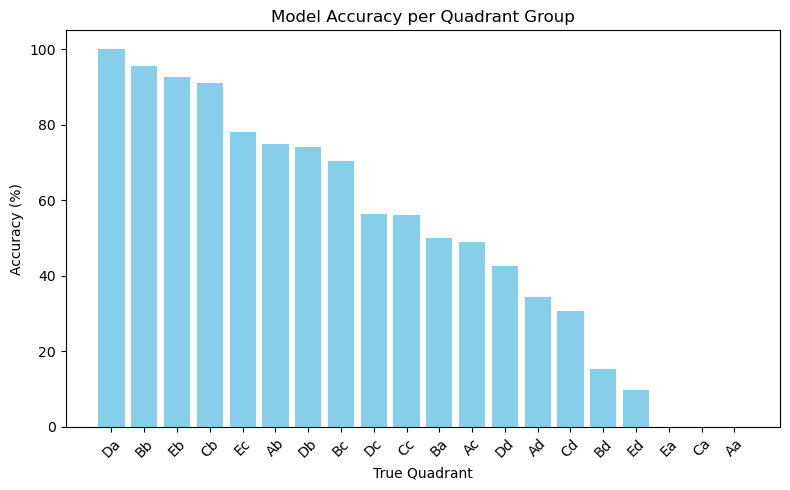

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(group_summary["quadrant"], group_summary["Accuracy (%)"], color="skyblue")
plt.title("Model Accuracy per Quadrant Group")
plt.xlabel("True Quadrant")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import plotly.graph_objects as go

df_result3 = comparison_df.copy()

# ✅ จัดกลุ่มหุ้นตาม quadrant
quadrant_groups = df_result3.groupby('Predicted Quadrant')['symbol'].apply(list).to_dict()

# ✅ ลำดับของแกน
financial_levels = ['A', 'B', 'C', 'D', 'E']  # A = Strong fundamentals
trend_levels = ['a', 'b', 'c', 'd', 'e']      # a = Bullish, e = Crash

# ✅ เตรียมข้อมูลแต่ละเซลล์
plot_table = []
for f in financial_levels:
    row = []
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_list = "<br>".join(stocks)  # ✅ แสดงหุ้นทั้งหมด
            cell_text = f"<b>{code}</b><br>{stock_list}"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row.append(cell_text)
    plot_table.append(row)

# ✅ สีพื้นหลังของแต่ละแถว
colors = [[{'A': '#2ecc71', 'B': '#58d68d', 'C': '#f4d03f', 'D': '#f39c12', 'E': '#e74c3c'}[f]]*5 for f in financial_levels]

# ✅ สร้างตาราง
fig = go.Figure(data=go.Table(
    header=dict(
        values=[f"<b>{t}</b>" for t in trend_levels],
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=14)
    ),
    cells=dict(
        values=plot_table,
        fill_color=colors,
        align="center",
        height=150,  # ✅ เพิ่มความสูงเพื่อรองรับข้อความมาก
        font=dict(color="white", size=11)
    )
))

# ✅ ชื่อกราฟ
fig.update_layout(title="📊 Stock Quadrant Table (Aa–Ee) — แสดงหุ้นทั้งหมดในแต่ละ Quadrant")
fig.show()
